## COVID-19 growth
Peter Attia, 2020-03-29

This notebook performs simple analysis of the growth in the number of patients with COVID-19. I don't have any particular objectives in mind, but I'm interested in digging deeper beyond what I see in the media.

This goes without saying, but I have little background in this subject. This analysis is solely to satisfy my own curiousity.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import altair as alt # conda install -c conda-forge altair vega_datasets

## Settings

List countries to plot here:

In [2]:
countries_to_plot = ['Germany', 'Italy', 'Spain', 'China', 'United States', 'South Korea', 'Japan', 'Iran']

## Load data
While a few different organizations publish COVID-19 data, I think data from the [ECDC](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) was among the cleanest. Note that since I'm pulling the data directly from the source, and the source is updating, this notebook will always run with up-to-date analysis. I've also saved a copy of the data from the day I performed the analysis locally.

In [3]:
df = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv', encoding='latin-1')
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,29/03/2020,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
1,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
2,27/03/2020,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
3,26/03/2020,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
4,25/03/2020,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0


In [4]:
df.describe()

,day,month,year,cases,deaths,popData2018
count,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,7.504000e+03
mean,17.143979,2.268929,2019.991084,87.443779,4.052029,7.046491e+07
std,8.439156,1.245780,0.094006,659.254504,38.319821,2.126148e+08
min,1.000000,1.000000,2019.000000,-9.000000,0.000000,1.000000e+03
25%,10.000000,1.000000,2020.000000,0.000000,0.000000,4.137309e+06
50%,18.000000,2.000000,2020.000000,0.000000,0.000000,1.072767e+07
75%,24.000000,3.000000,2020.000000,6.000000,0.000000,4.964868e+07
max,31.000000,12.000000,2020.000000,19979.000000,971.000000,1.392730e+09


Convert dates to US convention so Altair can process them, and delete unneeded columns:

In [5]:
df['Date'] = pd.to_datetime(df.month.astype(str) + '/' + df.day.astype(str) + '/' + df.year.astype(str))
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,Date
0,29/03/2020,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0,2020-03-29
1,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0,2020-03-28
2,27/03/2020,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0,2020-03-27
3,26/03/2020,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0,2020-03-26
4,25/03/2020,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0,2020-03-25


Do some cleaning:

In [6]:
df.replace(r'_', ' ', regex=True, inplace=True)
df.replace(r' of America', '', regex=True, inplace=True)
df.rename(columns={'cases': 'Daily cases', 'deaths': 'Daily deaths', 'countriesAndTerritories': 'Country'}, inplace=True)
df.sort_values(by=['Country','year','month','day'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index', 'day', 'month', 'year', 'dateRep', 'geoId', 'countryterritoryCode'], inplace=True)
df.head()

,Daily cases,Daily deaths,Country,popData2018,Date
0,0,0,Afghanistan,37172386.0,2019-12-31
1,0,0,Afghanistan,37172386.0,2020-01-01
2,0,0,Afghanistan,37172386.0,2020-01-02
3,0,0,Afghanistan,37172386.0,2020-01-03
4,0,0,Afghanistan,37172386.0,2020-01-04


Determine the number of days since the first reported case:

In [7]:
df['first_case'] = 0
df.loc[df['Daily cases'].ne(0).groupby(df['Country']).idxmax(),'first_case'] = 1
df['Days since first reported case'] = 0

for country, group in df.groupby('Country'):
    
    first_reported_date = group[group['first_case'] == 1].Date.iloc[0]
    df.loc[group.index, 'Days since first reported case'] = (group.Date - first_reported_date).dt.days
    
df.head()

,Daily cases,Daily deaths,Country,popData2018,Date,first_case,Days since first reported case
0,0,0,Afghanistan,37172386.0,2019-12-31,0,-56
1,0,0,Afghanistan,37172386.0,2020-01-01,0,-55
2,0,0,Afghanistan,37172386.0,2020-01-02,0,-54
3,0,0,Afghanistan,37172386.0,2020-01-03,0,-53
4,0,0,Afghanistan,37172386.0,2020-01-04,0,-52


Reorganize columns for clarity:

In [8]:
df = df[['Date', 'Days since first reported case', 'Country', 'popData2018', 'Daily cases', 'Daily deaths']]

Calculate total cases and total deaths from daily cases numbers:

In [9]:
df['Total cases'] = df.groupby('Country')['Daily cases'].cumsum().values
df['Total deaths'] = df.groupby('Country')['Daily deaths'].cumsum().values
df.head()

,Date,Days since first reported case,Country,popData2018,Daily cases,Daily deaths,Total cases,Total deaths
0,2019-12-31,-56,Afghanistan,37172386.0,0,0,0,0
1,2020-01-01,-55,Afghanistan,37172386.0,0,0,0,0
2,2020-01-02,-54,Afghanistan,37172386.0,0,0,0,0
3,2020-01-03,-53,Afghanistan,37172386.0,0,0,0,0
4,2020-01-04,-52,Afghanistan,37172386.0,0,0,0,0


Add columns for cases and deaths normalized by populations:

In [10]:
df['Total cases per 1 million people'] = (df['Total cases'] / df.popData2018 * 1e6).round(1)
df['Total deaths per 1 million people'] = (df['Total deaths'] / df.popData2018 * 1e6).round(1)

df['Daily cases per 1 million people'] = (df['Daily cases'] / df.popData2018 * 1e6).round(1)
df['Daily deaths per 1 million people'] = (df['Daily deaths'] / df.popData2018 * 1e6).round(1)

df

,Date,Days since first reported case,Country,popData2018,Daily cases,Daily deaths,Total cases,Total deaths,Total cases per 1 million people,Total deaths per 1 million people,Daily cases per 1 million people,Daily deaths per 1 million people
0,2019-12-31,-56,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0
1,2020-01-01,-55,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0
2,2020-01-02,-54,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0
3,2020-01-03,-53,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0
4,2020-01-04,-52,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7510,2020-03-25,4,Zimbabwe,14439018.0,0,0,2,1,0.1,0.1,0.0,0.0
7511,2020-03-26,5,Zimbabwe,14439018.0,1,0,3,1,0.2,0.1,0.1,0.0
7512,2020-03-27,6,Zimbabwe,14439018.0,0,0,3,1,0.2,0.1,0.0,0.0
7513,2020-03-28,7,Zimbabwe,14439018.0,2,0,5,1,0.3,0.1,0.1,0.0


Calculate cumulative death rate:

In [11]:
df['Cumulative death rate (%)'] = (100 * df['Total deaths'] / df['Total cases']).round(3)
df.head()

,Date,Days since first reported case,Country,popData2018,Daily cases,Daily deaths,Total cases,Total deaths,Total cases per 1 million people,Total deaths per 1 million people,Daily cases per 1 million people,Daily deaths per 1 million people,Cumulative death rate (%)
0,2019-12-31,-56,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN
1,2020-01-01,-55,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN
2,2020-01-02,-54,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN
3,2020-01-03,-53,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN
4,2020-01-04,-52,Afghanistan,37172386.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN


## Plots

Downselect dataframe using countries in list to plot:

In [12]:
df_reduced = df[df['Country'].isin(countries_to_plot)]

Create wrapper function for creating Altair plots:

In [13]:
def plot(yvar, xvar='Date:T'):
    selection = alt.selection_multi(fields=['Country'], bind='legend')
    
    # Adjust x axes limits if needed
    if xvar != 'Date:T':
        max_time = df_reduced['Days since first reported case'].max() + 5
        x = alt.X(xvar, scale=alt.Scale(domain=(0, max_time)))
    else:
        x = xvar
        
    print(xvar)
        
    chart = alt.Chart(df_reduced).mark_line().encode(
        x=x,
        y=yvar,
        color='Country:N',
        tooltip=['Country:N', xvar, yvar],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
    ).add_selection(
        selection
    ).interactive()
    
    # Add file saving appendix if xvar is different
    appendix = '_days' if xvar != 'Date:T' else ''
        
    chart.save(f'figures/{yvar}{appendix}.html')
    chart.display()

### Cases

In [14]:
plot('Total cases')

Date:T


alt.Chart(...)

In [15]:
plot('Total cases', xvar='Days since first reported case')

Days since first reported case


alt.Chart(...)

In [16]:
plot('Total cases per 1 million people')

Date:T


alt.Chart(...)

In [17]:
plot('Total cases per 1 million people', xvar='Days since first reported case')

Days since first reported case


alt.Chart(...)

In [18]:
plot('Daily cases')

Date:T


alt.Chart(...)

In [19]:
plot('Daily cases per 1 million people')

Date:T


alt.Chart(...)

### Deaths

In [20]:
plot('Total deaths')

Date:T


alt.Chart(...)

In [21]:
plot('Total deaths per 1 million people')

Date:T


alt.Chart(...)

In [22]:
plot('Daily deaths')

Date:T


alt.Chart(...)

In [23]:
plot('Daily deaths per 1 million people')

Date:T


alt.Chart(...)

### Death rate

In [24]:
plot('Cumulative death rate (%)')

Date:T


alt.Chart(...)

## Fitting exponential curves

I'm curious how these countries' case load growth fits to $y=Ae^{Bx}$. What do the parameters indicate

Note that I crop data past the exponential rise for 

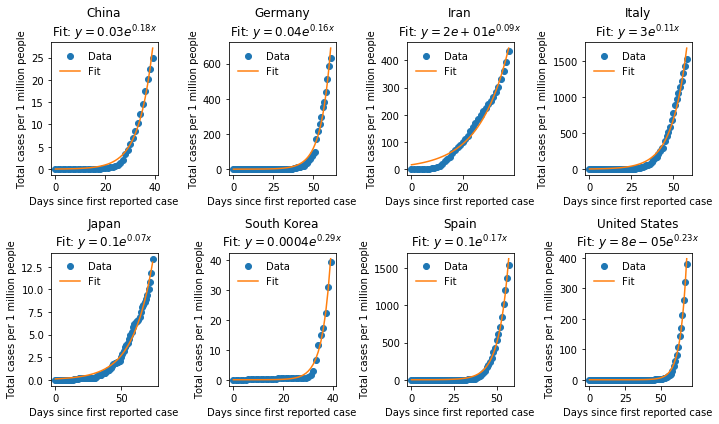

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,6))
ax = ax.ravel()

yvar = 'Total cases per 1 million people'

for k, (country, group) in enumerate(df_reduced.groupby('Country')):
    
    # Filter indices to only include exponential rise for South Korea and China
    if country == 'South Korea' or country == 'China':
        idx = (group['Days since first reported case'] >= 0) & (group['Days since first reported case'] < 40)
    else:
        idx = group['Days since first reported case'] >= 0
    
    days = group[idx]['Days since first reported case']
    cases = group[idx][yvar]
    
    # Perform fit
    exp = lambda x, a, b: a * np.exp(b * x)
    popt, pcov = curve_fit(exp, days, cases, p0=(10, 0.1))
    
    # Plot
    ax[k].plot(days, cases, 'o', label='Data')
    ax[k].plot(days, exp(days, *popt), label='Fit')
    ax[k].legend(frameon=False)
    
    ax[k].set_xlabel('Days since first reported case')
    ax[k].set_ylabel(yvar)
    ax[k].set_title(f'{country}\nFit: ' + r'$y=' + f'{popt[0]:0.1g}' + 'e^{' + f'{popt[1]:0.2f}' + 'x}$')

plt.tight_layout()
plt.savefig(f'figures/fits_{yvar}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/fits_{yvar}.svg', dpi=300, bbox_inches='tight')

The fits aren't perfect, but in lieu of overcomplicating the problem, I think these have acceptable accuracy.

Repeat for deaths:

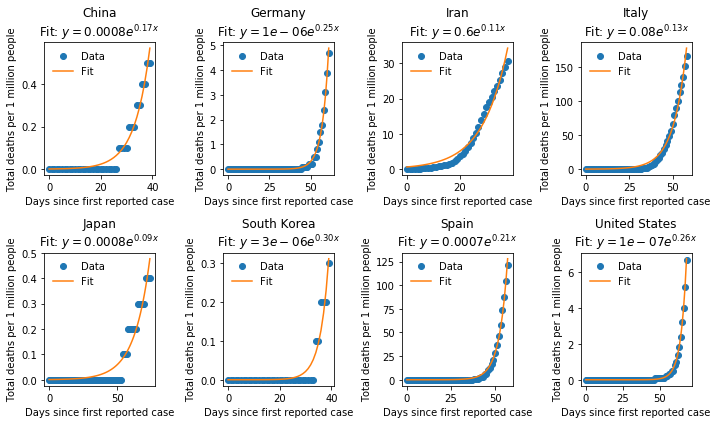

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,6))
ax = ax.ravel()

yvar = 'Total deaths per 1 million people'

for k, (country, group) in enumerate(df_reduced.groupby('Country')):
    
    # Filter indices to only include exponential rise for South Korea and China
    if country == 'South Korea' or country == 'China':
        idx = (group['Days since first reported case'] >= 0) & (group['Days since first reported case'] < 40)
    else:
        idx = group['Days since first reported case'] >= 0
    
    days = group[idx]['Days since first reported case']
    cases = group[idx][yvar]
    
    # Perform fit
    exp = lambda x,a,b: a * np.exp(b * x)
    popt, pcov = curve_fit(exp, days, cases, p0=(10, 0.1))
    
    # Plot
    ax[k].plot(days, cases, 'o', label='Data')
    ax[k].plot(days, exp(days, *popt), label='Fit')
    ax[k].legend(frameon=False)
    
    ax[k].set_xlabel('Days since first reported case')
    ax[k].set_ylabel(yvar)
    ax[k].set_title(f'{country}\nFit: ' + r'$y=' + f'{popt[0]:0.1g}' + 'e^{' + f'{popt[1]:0.2f}' + 'x}$')

plt.tight_layout()
plt.savefig(f'figures/fits_{yvar}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/fits_{yvar}.svg', dpi=300, bbox_inches='tight')